In [2]:
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip install tensorflow -q

In [3]:
!pip install kaggle

In [4]:
pip install PyDrive


In [5]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Data

In [6]:
# data processing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import holidays

import os

In [7]:
# modeling
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# visualization
import plotly.express as px

# Read DATA

In [8]:


client = pd.read_csv("/content/drive/MyDrive/CI/client.csv")
train = pd.read_csv("/content/drive/MyDrive/CI/train.csv")
forecast_weather = pd.read_csv("/content/drive/MyDrive/CI/forecast_weather.csv")
historical_weather = pd.read_csv("/content/drive/MyDrive/CI/historical_weather.csv")
gas_prices = pd.read_csv("/content/drive/MyDrive/CI/gas_prices.csv")
electricity_prices= pd.read_csv("/content/drive/MyDrive/CI/electricity_prices.csv")
weather_station_to_county_mapping = pd.read_csv("/content/drive/MyDrive/CI/weather_station_to_county_mapping.csv")

# EDA

In [9]:
client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,507,4960.215,0,2023-05-26,634
1,2,0,11,34.000,0,2023-05-26,634
2,3,0,1516,15977.560,0,2023-05-26,634
3,0,0,25,1273.200,1,2023-05-26,634
4,1,0,98,2885.600,1,2023-05-26,634


In [10]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [11]:
forecast_weather.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2023-05-27 02:00:00,1,9.859155,5.508813,0.0,0.0,0.026901,0.026901,3.616620,-1.281012,634,2023-05-27 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2023-05-27 02:00:00,1,5.916284,4.613428,0.0,0.0,0.000000,0.000000,2.164227,-0.245367,634,2023-05-27 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2023-05-27 02:00:00,1,9.111963,6.878442,0.0,0.0,0.000000,0.000000,3.809247,-1.583502,634,2023-05-27 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2023-05-27 02:00:00,1,10.746606,5.006372,0.0,0.0,0.000000,0.000000,4.106854,-5.625006,634,2023-05-27 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2023-05-27 02:00:00,1,10.791895,4.701074,0.0,0.0,0.000000,0.000000,4.188153,-7.184332,634,2023-05-27 03:00:00,0.0,0.0,0.0,0.0


In [12]:
historical_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2023-05-26 11:00:00,13.5,9.0,0.0,0.0,1018.5,30,31,3,0,6.305556,272,592.0,420.0,172.0,57.6,21.7,634.0
1,2023-05-26 11:00:00,13.4,8.9,0.2,0.0,1013.2,47,31,32,0,6.111111,268,612.0,446.0,166.0,57.6,22.2,634.0
2,2023-05-26 11:00:00,16.4,7.8,0.2,0.0,1017.7,60,21,69,0,6.138889,263,655.0,512.0,143.0,57.6,22.7,634.0
3,2023-05-26 11:00:00,-0.1,-2.0,0.0,0.0,1024.1,100,100,100,100,7.166667,167,0.0,0.0,0.0,57.6,23.2,634.0
4,2023-05-26 11:00:00,14.4,6.4,0.0,0.0,1017.8,29,8,37,0,5.000000,233,730.0,614.0,116.0,57.6,23.7,634.0


In [13]:
gas_prices.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2023-05-27,28.30,34.10,2023-05-26,634
1,2023-05-28,28.10,34.10,2023-05-27,635
2,2023-05-29,28.16,36.98,2023-05-28,636
3,2023-05-30,29.00,34.00,2023-05-29,637


In [14]:
electricity_prices.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2023-05-27 00:00:00,87.54,2023-05-26 00:00:00,634
1,2023-05-27 01:00:00,82.69,2023-05-26 01:00:00,634
2,2023-05-27 02:00:00,82.70,2023-05-26 02:00:00,634
3,2023-05-27 03:00:00,84.26,2023-05-26 03:00:00,634
4,2023-05-27 04:00:00,87.67,2023-05-26 04:00:00,634


# Train

In [15]:
max(train["prediction_unit_id"])

68

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB


<ipython-input-17-6e05f797fda8>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_sample_pro = train[train['prediction_unit_id'] == 0][train['is_consumption'] == 0]
<ipython-input-17-6e05f797fda8>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_sample_con = train[train['prediction_unit_id'] == 0][train['is_consumption'] == 1]
<ipython-input-17-6e05f797fda8>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_sample_pro = train[train['prediction_unit_id'] == 1][train['is_consumption'] == 0]
<ipython-input-17-6e05f797fda8>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_sample_con = train[train['prediction_unit_id'] == 1][train['is_consumption'] == 1]


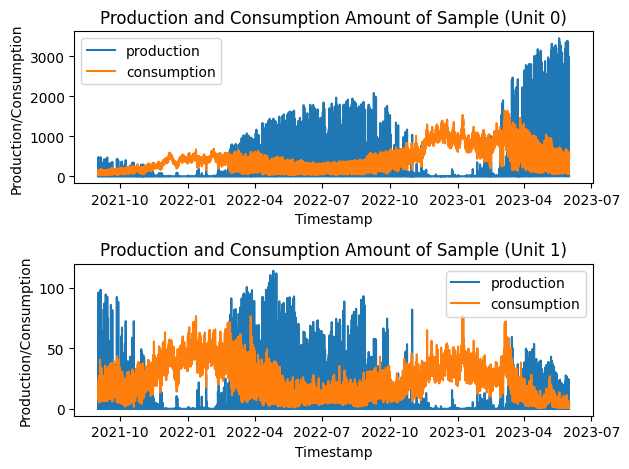

In [17]:
plt.subplot(2,1,1)
train_sample_pro = train[train['prediction_unit_id'] == 0][train['is_consumption'] == 0]
train_sample_pro['datetime']= pd.to_datetime(train_sample_pro['datetime'])
train_sample_con = train[train['prediction_unit_id'] == 0][train['is_consumption'] == 1]
train_sample_con['datetime']= pd.to_datetime(train_sample_con['datetime'])
plt.plot(train_sample_pro["datetime"],train_sample_pro["target"],label='production')
plt.plot(train_sample_con["datetime"],train_sample_con["target"],label='consumption')
plt.title('Production and Consumption Amount of Sample (Unit 0)')
plt.xlabel('Timestamp')
plt.ylabel('Production/Consumption')
plt.legend()


plt.subplot(2,1,2)
train_sample_pro = train[train['prediction_unit_id'] == 1][train['is_consumption'] == 0]
train_sample_pro['datetime']= pd.to_datetime(train_sample_pro['datetime'])
train_sample_con = train[train['prediction_unit_id'] == 1][train['is_consumption'] == 1]
train_sample_con['datetime']= pd.to_datetime(train_sample_con['datetime'])
plt.plot(train_sample_pro["datetime"],train_sample_pro["target"],label='production')
plt.plot(train_sample_con["datetime"],train_sample_con["target"],label='consumption')
plt.title('Production and Consumption Amount of Sample (Unit 1)')
plt.xlabel('Timestamp')
plt.ylabel('Production/Consumption')
plt.legend()

plt.tight_layout()
plt.show()
# subplot

**train.csv**



*  Production and Consumption Amount of Sample (Unit 0) visualization has been listed above.
*  train.csv includes 68 production units
data datetime ranging from 2021.9.1 to 2023.5.31





# Client

In [18]:
client

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,507,4960.215,0,2023-05-26,634
1,2,0,11,34.000,0,2023-05-26,634
2,3,0,1516,15977.560,0,2023-05-26,634
3,0,0,25,1273.200,1,2023-05-26,634
4,1,0,98,2885.600,1,2023-05-26,634
...,...,...,...,...,...,...,...
257,1,15,51,415.600,0,2023-05-29,637
258,3,15,161,2035.750,0,2023-05-29,637
259,0,15,15,620.000,1,2023-05-29,637
260,1,15,20,624.500,1,2023-05-29,637


<ipython-input-19-ea279a489a96>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  client_sampe = client[client['county'] == 0][client['is_business'] == 0][client['product_type'] == 1]
<ipython-input-19-ea279a489a96>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  client_sampe = client[client['county'] == 0][client['is_business'] == 0][client['product_type'] == 1]
<ipython-input-19-ea279a489a96>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  client_sampe = client[client['county'] == 0][client['is_business'] == 0][client['product_type'] == 2]
<ipython-input-19-ea279a489a96>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  client_sampe = client[client['county'] == 0][client['is_business'] == 0][client['product_type'] == 2]


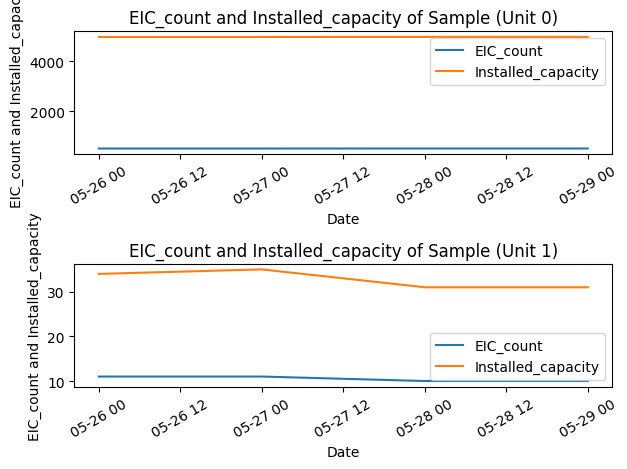

In [19]:
plt.subplot(2,1,1)
client_sampe = client[client['county'] == 0][client['is_business'] == 0][client['product_type'] == 1]
client_sampe['date']= pd.to_datetime(client_sampe['date'])
plt.plot(client_sampe["date"],client_sampe["eic_count"],label='EIC_count')
plt.plot(client_sampe["date"],client_sampe["installed_capacity"],label='Installed_capacity')
plt.title('EIC_count and Installed_capacity of Sample (Unit 0)')
plt.xlabel('Date')
plt.ylabel('EIC_count and Installed_capacity')
plt.xticks(rotation=30)
plt.legend()

plt.subplot(2,1,2)
client_sampe = client[client['county'] == 0][client['is_business'] == 0][client['product_type'] == 2]
client_sampe['date']= pd.to_datetime(client_sampe['date'])
plt.plot(client_sampe["date"],client_sampe["eic_count"],label='EIC_count')
plt.plot(client_sampe["date"],client_sampe["installed_capacity"],label='Installed_capacity')
plt.title('EIC_count and Installed_capacity of Sample (Unit 1)')
plt.xlabel('Date')
plt.ylabel('EIC_count and Installed_capacity')
plt.xticks(rotation=30)
plt.legend()

plt.tight_layout()
plt.show()
#sub plot

**client.csv**

*   data datetime ranging from 2021.9.1 to 2023.5.29
*   EIC_count and installed_capacity of Sample (Unit 0) visualization has been listed above






# Electricity

In [20]:
electricity_prices

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2023-05-27 00:00:00,87.54,2023-05-26 00:00:00,634
1,2023-05-27 01:00:00,82.69,2023-05-26 01:00:00,634
2,2023-05-27 02:00:00,82.70,2023-05-26 02:00:00,634
3,2023-05-27 03:00:00,84.26,2023-05-26 03:00:00,634
4,2023-05-27 04:00:00,87.67,2023-05-26 04:00:00,634
...,...,...,...,...
91,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,637
92,2023-05-30 20:00:00,150.85,2023-05-29 20:00:00,637
93,2023-05-30 21:00:00,82.10,2023-05-29 21:00:00,637
94,2023-05-30 22:00:00,82.09,2023-05-29 22:00:00,637


In [21]:
#outlier dealing
electricity_prices[electricity_prices["euros_per_mwh"] == max(electricity_prices["euros_per_mwh"])]
electricity_prices.loc[electricity_prices["euros_per_mwh"] == max(electricity_prices["euros_per_mwh"]),"euros_per_mwh"] = 1000

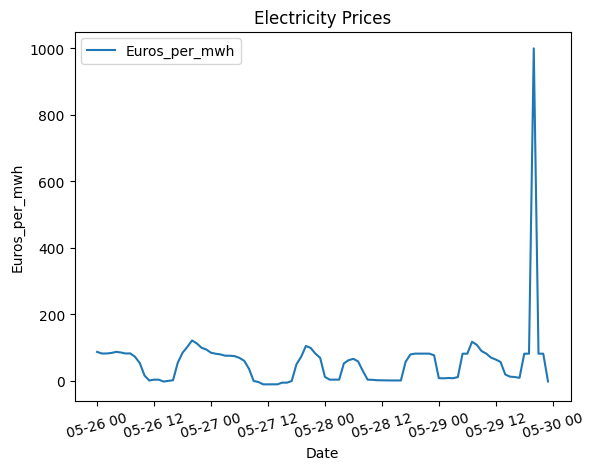

In [22]:
electricity_prices['origin_date']= pd.to_datetime(electricity_prices['origin_date'])
plt.plot(electricity_prices["origin_date"],electricity_prices["euros_per_mwh"],label='Euros_per_mwh')
plt.title('Electricity Prices')
plt.xlabel('Date')
plt.ylabel('Euros_per_mwh')
plt.xticks(rotation=15)
plt.legend()

**electricity_prices.csv**

*   data forecast date ranging from 2021.9.1 to 2023.5.30
*   electricity prices euros_per_mwh visualization has been listed above.






# Gas

In [23]:
gas_prices

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2023-05-27,28.30,34.10,2023-05-26,634
1,2023-05-28,28.10,34.10,2023-05-27,635
2,2023-05-29,28.16,36.98,2023-05-28,636
3,2023-05-30,29.00,34.00,2023-05-29,637


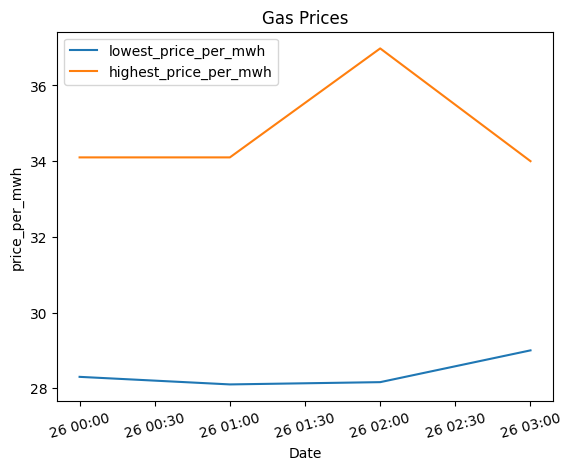

In [24]:
gas_prices['origin_date']= pd.to_datetime(electricity_prices['origin_date'])
plt.plot(gas_prices["origin_date"],gas_prices["lowest_price_per_mwh"],label='lowest_price_per_mwh')
plt.plot(gas_prices["origin_date"],gas_prices["highest_price_per_mwh"],label='highest_price_per_mwh')
plt.title('Gas Prices')
plt.xlabel('Date')
plt.ylabel('price_per_mwh')
plt.xticks(rotation=15)
plt.legend()

**gas_prices.csv**

*   data forecast date ranging from 2021.9.1 to 2023.5.30
*   gas prices lowest_price_per_mwh and highest_price_per_mwh visualization has been listed above.






# historical_weather

In [25]:
historical_weather

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2023-05-26 11:00:00,13.5,9.0,0.0,0.0,1018.5,30,31,3,0,6.305556,272,592.0,420.0,172.0,57.6,21.7,634.0
1,2023-05-26 11:00:00,13.4,8.9,0.2,0.0,1013.2,47,31,32,0,6.111111,268,612.0,446.0,166.0,57.6,22.2,634.0
2,2023-05-26 11:00:00,16.4,7.8,0.2,0.0,1017.7,60,21,69,0,6.138889,263,655.0,512.0,143.0,57.6,22.7,634.0
3,2023-05-26 11:00:00,-0.1,-2.0,0.0,0.0,1024.1,100,100,100,100,7.166667,167,0.0,0.0,0.0,57.6,23.2,634.0
4,2023-05-26 11:00:00,14.4,6.4,0.0,0.0,1017.8,29,8,37,0,5.000000,233,730.0,614.0,116.0,57.6,23.7,634.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10747,2023-05-30 10:00:00,11.7,4.6,0.0,0.0,1018.9,40,9,54,0,1.055556,253,567.0,392.0,175.0,59.7,26.2,637.0
10748,2023-05-30 10:00:00,12.3,3.5,0.0,0.0,1019.0,46,4,70,0,0.805556,263,581.0,407.0,174.0,59.7,26.7,637.0
10749,2023-05-30 10:00:00,9.8,3.0,0.0,0.0,1019.2,41,4,62,0,1.972222,285,609.0,432.0,177.0,59.7,27.2,637.0
10750,2023-05-30 10:00:00,11.7,1.6,0.0,0.0,1019.0,44,0,73,0,3.500000,307,658.0,521.0,137.0,59.7,27.7,637.0


In [26]:
historical_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10752 entries, 0 to 10751
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   datetime                10752 non-null  object 
 1   temperature             10752 non-null  float64
 2   dewpoint                10752 non-null  float64
 3   rain                    10752 non-null  float64
 4   snowfall                10752 non-null  float64
 5   surface_pressure        10752 non-null  float64
 6   cloudcover_total        10752 non-null  int64  
 7   cloudcover_low          10752 non-null  int64  
 8   cloudcover_mid          10752 non-null  int64  
 9   cloudcover_high         10752 non-null  int64  
 10  windspeed_10m           10752 non-null  float64
 11  winddirection_10m       10752 non-null  int64  
 12  shortwave_radiation     10752 non-null  float64
 13  direct_solar_radiation  10752 non-null  float64
 14  diffuse_radiation       10752 non-null

In [27]:
#sample Saaremaa longitude == 22.2 latitude == 58.2 county == 10  2021-09
historical_weather_sample = historical_weather[abs(historical_weather["longitude"] - 22.1) < 0.1][abs(historical_weather["latitude"] - 58.2) < 0.1][historical_weather["datetime"]<"2021-10-01"]
historical_weather_sample


# abs() function is used to calculate the absolute difference between the longitude/latitude values in the historical_weather DataFrame and the target longitude/latitude coordinates for the Saaremaa region.

<ipython-input-27-ca3e60e02307>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  historical_weather_sample = historical_weather[abs(historical_weather["longitude"] - 22.1) < 0.1][abs(historical_weather["latitude"] - 58.2) < 0.1][historical_weather["datetime"]<"2021-10-01"]
<ipython-input-27-ca3e60e02307>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  historical_weather_sample = historical_weather[abs(historical_weather["longitude"] - 22.1) < 0.1][abs(historical_weather["latitude"] - 58.2) < 0.1][historical_weather["datetime"]<"2021-10-01"]


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id


<ipython-input-28-248f74ce9911>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  historical_weather_sample = historical_weather[abs(historical_weather["longitude"] - 22.1) < 0.1][abs(historical_weather["latitude"] - 58.2) < 0.1][historical_weather["datetime"]<"2021-10-01"]
<ipython-input-28-248f74ce9911>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  historical_weather_sample = historical_weather[abs(historical_weather["longitude"] - 22.1) < 0.1][abs(historical_weather["latitude"] - 58.2) < 0.1][historical_weather["datetime"]<"2021-10-01"]
<ipython-input-28-248f74ce9911>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  historical_weather_sample = historical_weather[abs(historical_weather["longitude"] - 22.7) < 0.1][abs(historical_weather["latitude"] - 58.8) < 0.1][historical_weather["datetime"]<"2021-10-01"]
<ipython-input-28-248f74ce9911>:16: UserWarning: Boolean Series key will be reind

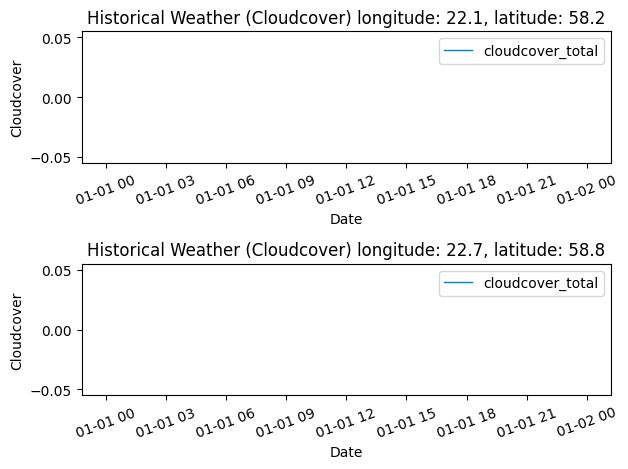

In [28]:
# cloudcover_total cloudcover_low cloudcover_mid cloudcover_high
plt.subplot(2,1,1)
historical_weather_sample = historical_weather[abs(historical_weather["longitude"] - 22.1) < 0.1][abs(historical_weather["latitude"] - 58.2) < 0.1][historical_weather["datetime"]<"2021-10-01"]
historical_weather_sample['datetime']= pd.to_datetime(historical_weather_sample['datetime'])
plt.plot(historical_weather_sample['datetime'],historical_weather_sample["cloudcover_total"],label='cloudcover_total', linewidth = 1)
# plt.plot(historical_weather_sample['datetime'],historical_weather_sample["cloudcover_low"],label='cloudcover_low', linewidth = 1)
# plt.plot(historical_weather_sample['datetime'],historical_weather_sample["cloudcover_mid"],label='cloudcover_mid', linewidth = 1)
# plt.plot(historical_weather_sample['datetime'],historical_weather_sample["cloudcover_high"],label='cloudcover_high', linewidth = 1)
plt.title('Historical Weather (Cloudcover) longitude: 22.1, latitude: 58.2')
plt.xlabel('Date')
plt.ylabel('Cloudcover')
plt.xticks(rotation=20)
plt.legend()

plt.subplot(2,1,2)
historical_weather_sample = historical_weather[abs(historical_weather["longitude"] - 22.7) < 0.1][abs(historical_weather["latitude"] - 58.8) < 0.1][historical_weather["datetime"]<"2021-10-01"]
historical_weather_sample['datetime']= pd.to_datetime(historical_weather_sample['datetime'])
plt.plot(historical_weather_sample['datetime'],historical_weather_sample["cloudcover_total"],label='cloudcover_total', linewidth = 1)
# plt.plot(historical_weather_sample['datetime'],historical_weather_sample["cloudcover_low"],label='cloudcover_low', linewidth = 1)
# plt.plot(historical_weather_sample['datetime'],historical_weather_sample["cloudcover_mid"],label='cloudcover_mid', linewidth = 1)
# plt.plot(historical_weather_sample['datetime'],historical_weather_sample["cloudcover_high"],label='cloudcover_high', linewidth = 1)
plt.title('Historical Weather (Cloudcover) longitude: 22.7, latitude: 58.8')
plt.xlabel('Date')
plt.ylabel('Cloudcover')
plt.xticks(rotation=20)
plt.legend()

plt.tight_layout()
plt.show()
# subplot

<ipython-input-29-b1081120ed61>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  historical_weather_sample = historical_weather[abs(historical_weather["longitude"] - 22.1) < 0.1][abs(historical_weather["latitude"] - 58.2) < 0.1][historical_weather["datetime"]<"2021-10-01"]
<ipython-input-29-b1081120ed61>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  historical_weather_sample = historical_weather[abs(historical_weather["longitude"] - 22.1) < 0.1][abs(historical_weather["latitude"] - 58.2) < 0.1][historical_weather["datetime"]<"2021-10-01"]
<ipython-input-29-b1081120ed61>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  historical_weather_sample = historical_weather[abs(historical_weather["longitude"] - 22.7) < 0.1][abs(historical_weather["latitude"] - 58.8) < 0.1][historical_weather["datetime"]<"2021-10-01"]
<ipython-input-29-b1081120ed61>:15: UserWarning: Boolean Series key will be reind

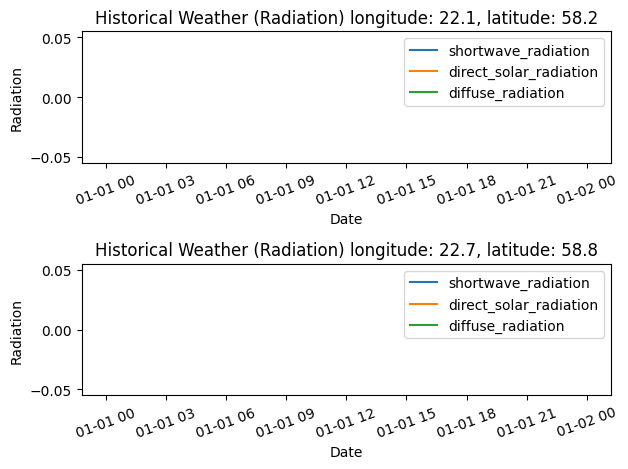

In [29]:
# shortwave_radiation direct_solar_radiation diffuse_radiation
plt.subplot(2,1,1)
historical_weather_sample = historical_weather[abs(historical_weather["longitude"] - 22.1) < 0.1][abs(historical_weather["latitude"] - 58.2) < 0.1][historical_weather["datetime"]<"2021-10-01"]
historical_weather_sample['datetime']= pd.to_datetime(historical_weather_sample['datetime'])
plt.plot(historical_weather_sample['datetime'],historical_weather_sample["shortwave_radiation"],label='shortwave_radiation')
plt.plot(historical_weather_sample['datetime'],historical_weather_sample["direct_solar_radiation"],label='direct_solar_radiation')
plt.plot(historical_weather_sample['datetime'],historical_weather_sample["diffuse_radiation"],label='diffuse_radiation')
plt.title('Historical Weather (Radiation) longitude: 22.1, latitude: 58.2')
plt.xlabel('Date')
plt.ylabel('Radiation')
plt.xticks(rotation=20)
plt.legend()

plt.subplot(2,1,2)
historical_weather_sample = historical_weather[abs(historical_weather["longitude"] - 22.7) < 0.1][abs(historical_weather["latitude"] - 58.8) < 0.1][historical_weather["datetime"]<"2021-10-01"]
historical_weather_sample['datetime']= pd.to_datetime(historical_weather_sample['datetime'])
plt.plot(historical_weather_sample['datetime'],historical_weather_sample["shortwave_radiation"],label='shortwave_radiation')
plt.plot(historical_weather_sample['datetime'],historical_weather_sample["direct_solar_radiation"],label='direct_solar_radiation')
plt.plot(historical_weather_sample['datetime'],historical_weather_sample["diffuse_radiation"],label='diffuse_radiation')
plt.title('Historical Weather (Radiation) longitude: 22.7, latitude: 58.8')
plt.xlabel('Date')
plt.ylabel('Radiation')
plt.xticks(rotation=20)
plt.legend()


plt.tight_layout() #to keep the legend inside the graph
plt.show()
# subplot


# forecast weather

In [30]:
forecast_weather

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2023-05-27 02:00:00,1,9.859155,5.508813,0.000000,0.000000,0.026901,0.026901,3.616620,-1.281012,634,2023-05-27 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2023-05-27 02:00:00,1,5.916284,4.613428,0.000000,0.000000,0.000000,0.000000,2.164227,-0.245367,634,2023-05-27 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2023-05-27 02:00:00,1,9.111963,6.878442,0.000000,0.000000,0.000000,0.000000,3.809247,-1.583502,634,2023-05-27 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2023-05-27 02:00:00,1,10.746606,5.006372,0.000000,0.000000,0.000000,0.000000,4.106854,-5.625006,634,2023-05-27 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2023-05-27 02:00:00,1,10.791895,4.701074,0.000000,0.000000,0.000000,0.000000,4.188153,-7.184332,634,2023-05-27 03:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21499,59.7,26.2,2023-05-30 02:00:00,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0
21500,59.7,26.7,2023-05-30 02:00:00,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0
21501,59.7,27.2,2023-05-30 02:00:00,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0
21502,59.7,27.7,2023-05-30 02:00:00,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0


In [31]:
weather_station_to_county_mapping

,county_name,longitude,latitude,county
0,NaN,21.7,57.6,NaN
1,NaN,21.7,57.9,NaN
2,NaN,21.7,58.2,NaN
3,NaN,21.7,58.5,NaN
4,NaN,21.7,58.8,NaN
...,...,...,...,...
107,NaN,28.2,58.5,NaN
108,NaN,28.2,58.8,NaN
109,NaN,28.2,59.1,NaN
110,NaN,28.2,59.4,NaN


In [32]:
import plotly.express as px

In [33]:
weather_station_to_county_mapping['size'] = 2
fig = px.scatter_mapbox(
    weather_station_to_county_mapping,
    lat="latitude",
    lon="longitude",
    color="county",
    size="size",
    zoom=6,
    title='Weather Stations Locations'
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

In [34]:
# how big subset of the data to include in dataset
data_sample_size = 10000

# Preprocess



*   Add weather station data into weather data
*   Add information about the closest weather station into the weather data.




In [35]:
weather_station_to_county_mapping.head()

,county_name,longitude,latitude,county,size
0,NaN,21.7,57.6,NaN,2
1,NaN,21.7,57.9,NaN,2
2,NaN,21.7,58.2,NaN,2
3,NaN,21.7,58.5,NaN,2
4,NaN,21.7,58.8,NaN,2


In [36]:
print("Number of weather stations: ", len(weather_station_to_county_mapping))

Number of weather stations:  112


In [37]:
print("Number stations with county info: ", len(weather_station_to_county_mapping[~weather_station_to_county_mapping["county"].isna()]))

Number stations with county info:  49


We need county info to connect weather data into prosumer data. Since, let's use only stations with county info available. For each weather data row, let's find the closest weather station with county info available.

In [38]:
def find_closest_weather_station(point: pd.Series, wss: pd.DataFrame):
    """
    Find closest weather station with county information to a point.
    """

    point_coordinates = [point.latitude, point.longitude]
    weather_station_coordinates = [[ws.latitude, ws.longitude] for ws in wss.itertuples()]

    # calculate distances to every weather station
    dists = [distance.distance(point_coordinates, station).km
             for station in weather_station_coordinates]
    # get closest station
    closest_dist = np.min(dists)
    closest_station = wss.iloc[np.argmin(dists), :]
    return closest_station, closest_dist

In [39]:
def process_weather_data(wd: pd.DataFrame, wss: pd.DataFrame, feature_names: list):
    """
    Process weather data by
    - Adding weather station info to weather data by finding the closest weather station to a point
    """

    county_names = []
    county_ids = []
    for row in wd.itertuples():
        closest_station, dist = find_closest_weather_station(row, wss)
        if dist < 30:  # if station is less than 30 km away from point
            county_names.append(closest_station.county_name)
            county_ids.append(closest_station.county)
        else:
            county_names.append(None)
            county_ids.append(None)


    # add info to weather data
    wd_processed = wd.copy()
    wd_processed["county_name"] = county_names
    wd_processed["county"] = county_ids


    # take only data points from weather stations where county info is available
    wd_processed = wd_processed.dropna(subset=["county"], axis=0)

    # format timestamps
    wd_processed["forecast_datetime"] = wd_processed.forecast_datetime.apply(lambda x: pd.to_datetime(x).tz_localize(None).strftime("%Y-%m-%d %H:%M:%S"))

    # aggregate data per county, per timestamp
    wd_processed = wd_processed.groupby(["county", "forecast_datetime"])[feature_names].mean()

    return wd_processed

# Add capacity and consumption info for prosumers

In [40]:
# capacity and consumption info is found in client.csv-file
client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,507,4960.215,0,2023-05-26,634
1,2,0,11,34.000,0,2023-05-26,634
2,3,0,1516,15977.560,0,2023-05-26,634
3,0,0,25,1273.200,1,2023-05-26,634
4,1,0,98,2885.600,1,2023-05-26,634


In [41]:
def process_prosumer_data(train: pd.DataFrame, clients: pd.DataFrame):
    """
    Process prosumer data by adding capacity and consumption info into it.
    """
    prosumers_proc = train.copy()
    # add feature for date
    prosumers_proc["date"] = prosumers_proc.datetime.apply(lambda x: pd.to_datetime(x).strftime("%Y-%m-%d"))

    # calculate consumption and capacity per segment per date
    cons = client.groupby(["product_type", "county", "is_business", "date"])["eic_count"].sum()
    cap = client.groupby(["product_type", "county", "is_business", "date"])["installed_capacity"].sum()

    # add to prosumer data
    prosumers_proc = pd.merge(pd.merge(prosumers_proc, cons, on=["product_type", "county", "is_business", "date"]), cap, on=["product_type", "county", "is_business", "date"])

    return prosumers_proc

In [42]:
def process_elec_price_data(data: pd.DataFrame):
    """
    Process electricity price data.
    """

    data_processed = data.rename(columns={"euros_per_mwh": "electricity_price"})
    return data_processed

In [43]:
def process_gas_price_data(data: pd.DataFrame):
    """
    Process gas price data.
    """
    data_processed = data.copy()
    data_processed["avg_gas_price"] = data.apply(lambda row: np.mean([row.lowest_price_per_mwh, row.highest_price_per_mwh]), axis=1)
    return data_processed

#  Feature selection

Make dataset

In [44]:
def make_dataset(train: pd.DataFrame,
                 forecast_weather: pd.DataFrame,
                 weather_station_to_county_mapping: pd.DataFrame,
                 client: pd.DataFrame,
                 electricity_prices: pd.DataFrame,
                 gas_prices: pd.DataFrame,
                 weather_feature_names: list,
                 scaler
                 ):
    """
    Make dataset for predicting prosumer consumption and production.
    """
    # Ensure 'county' columns are of the same type (string)
    train['county'] = train['county'].astype(str)
    weather_station_to_county_mapping['county'] = weather_station_to_county_mapping['county'].astype(str)
    client['county'] = client['county'].astype(str)

    # Initialize the 'data' DataFrame with the 'train' DataFrame
    data = train.copy()
    print("Initial DataFrame columns:", data.columns)

    # Merge forecast weather data on 'data_block_id'
    data = data.merge(forecast_weather, how='left', on='data_block_id')
    print("After merging forecast weather, columns:", data.columns)

    # Debug: Check if 'county' still exists and is not empty
    if 'county' not in data.columns:
        raise KeyError("'county' column is missing after merging forecast weather.")
    if data['county'].isnull().all():
        raise ValueError("'county' column has only null values after merging forecast weather.")

    # Add other features using 'data_block_id' and 'county' for merging
    data = data.merge(weather_station_to_county_mapping[['county_name', 'county']],
                      how='left', left_on='county', right_on='county_name')
    print("After merging with weather_station_to_county_mapping, columns:", data.columns)

    # Handle the duplicated 'county' columns
    data['county'] = data['county_y']  # Choose 'county_y' or 'county_x' as needed
    data = data.drop(columns=['county_x', 'county_y', 'county_name'])  # Drop unnecessary columns

    # Debug: Check if 'county' exists
    if 'county' not in data.columns:
        raise KeyError("'county' column is missing after handling merge conflicts.")

    # Merge client data
    data = data.merge(client, how='left', on=['county', 'data_block_id'])
    print("After merging client data, columns:", data.columns)

    # Merge electricity prices
    data = data.merge(electricity_prices, how='left', on='data_block_id')
    print("After merging electricity prices, columns:", data.columns)

    # Merge gas prices
    data = data.merge(gas_prices, how='left', on='data_block_id')
    print("After merging gas prices, columns:", data.columns)

    # Debug: Ensure all necessary columns are present before selection
    print("Columns before feature selection:", data.columns)

    # Select relevant features including the target
    feats = ["is_consumption", "eic_count", "installed_capacity", "euros_per_mwh", "lowest_price_per_mwh"] + weather_feature_names + ["target"]
    data = data.loc[:, feats].reset_index(drop=True)  # Use .loc to avoid SettingWithCopyWarning

    print("Columns after feature selection:", data.columns)

    if scaler is not None:
        # Exclude datetime columns before scaling
        datetime_columns = data.select_dtypes(include=['datetime']).columns
        numerical_data = data.drop(datetime_columns, axis=1)  # Select only numerical columns

        target = numerical_data["target"]  # Extract target from numerical data

        scaled_data = pd.DataFrame(scaler.fit_transform(numerical_data.drop("target", axis=1)),
                                   columns=numerical_data.drop("target", axis=1).columns)
        scaled_data["target"] = target  # Add target back to scaled data

        # Add datetime columns back to the scaled data
        scaled_data[datetime_columns] = data[datetime_columns]

        data = scaled_data  # Update data with scaled data including datetime columns

    return data

In [45]:
# select which weather parameters to use
weather_feat_names = ['direct_solar_radiation','surface_solar_radiation_downwards']

In [46]:
# select scaler
scaler = StandardScaler()

In [47]:
forecast_weather

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2023-05-27 02:00:00,1,9.859155,5.508813,0.000000,0.000000,0.026901,0.026901,3.616620,-1.281012,634,2023-05-27 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2023-05-27 02:00:00,1,5.916284,4.613428,0.000000,0.000000,0.000000,0.000000,2.164227,-0.245367,634,2023-05-27 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2023-05-27 02:00:00,1,9.111963,6.878442,0.000000,0.000000,0.000000,0.000000,3.809247,-1.583502,634,2023-05-27 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2023-05-27 02:00:00,1,10.746606,5.006372,0.000000,0.000000,0.000000,0.000000,4.106854,-5.625006,634,2023-05-27 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2023-05-27 02:00:00,1,10.791895,4.701074,0.000000,0.000000,0.000000,0.000000,4.188153,-7.184332,634,2023-05-27 03:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21499,59.7,26.2,2023-05-30 02:00:00,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0
21500,59.7,26.7,2023-05-30 02:00:00,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0
21501,59.7,27.2,2023-05-30 02:00:00,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0
21502,59.7,27.7,2023-05-30 02:00:00,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0


In [48]:
# create dataset
dataset = make_dataset(train.head(data_sample_size),
                       forecast_weather.iloc[:data_sample_size, :],
                       weather_station_to_county_mapping,
                       client,
                       electricity_prices,
                       gas_prices,
                       ["direct_solar_radiation", "surface_solar_radiation_downwards"],
                       scaler
                       )

<ipython-input-44-05243096acd8>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Initial DataFrame columns: Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'datetime', 'data_block_id', 'row_id', 'prediction_unit_id'],
      dtype='object')
After merging forecast weather, columns: Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'datetime', 'data_block_id', 'row_id', 'prediction_unit_id', 'latitude',
       'longitude', 'origin_datetime', 'hours_ahead', 'temperature',
       'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_total', '10_metre_u_wind_component',
       '10_metre_v_wind_component', 'forecast_datetime',
       'direct_solar_radiation', 'surface_solar_radiation_downwards',
       'snowfall', 'total_precipitation'],
      dtype='object')
After merging with weather_station_to_county_mapping, columns: Index(['county_x', 'is_business', 'product_type', 'target', 'is_consumption',
       'datetime', 'data_block_id', 'row_id', 'prediction_unit_id', 'latitude

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1050: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1055: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1075: RuntimeWarning:

invalid value encountered in divide



In [49]:
print("Size of the dataset: ", dataset.shape)

Size of the dataset:  (10000, 8)


# Modeling

Let's define three different models to be fit into training data. The fitted models are later used to predict prosumers' energy consumption and production.

Let's try to find the best model out of the three by applying the K-Fold method. In this method, each model is fit into subsets of the training data at the time, and their performance is evaluated by predicting values for other subset of the data.

In [50]:
def create_rf_model():
    """
    Create a Random Forest model
    """
    model = RandomForestRegressor()
    return model

In [51]:
def create_svm_model():
    """
    Create a Support Vector Machine model
    """

    model = svm.SVR()
    return model

In [52]:
def create_nn_model():
    """
    Create a neural network model
    """
    model = keras.Sequential()
    model.add(keras.layers.Dense(64))
    model.add(keras.layers.Dense(32))
    model.add(keras.layers.Dense(16))
    model.add(keras.layers.Dense(8))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer="adam", loss="mae")

    return model

# K-fold cross validation

In [53]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset.drop("target", axis=1), dataset.target, test_size=0.2)

In [54]:
def cross_validate(data: pd.DataFrame, models, n_splits):
    """
    Cross validate different models to find out the best fitting model for the data.
    """

    kf = KFold(n_splits=10)
    # for storing results
    kfold_results = {}

    # define independent and dependent varibles
    X = dataset.iloc[:, :-1]
    y = dataset.target

    # cross validate
    run = 1
    for train_idx, test_idx in kf.split(X):
        scores = {}

        # define training and test sets
        X_train, X_test, y_train, y_test = X.iloc[train_idx, :], X.iloc[test_idx, :], y.iloc[train_idx], y.iloc[test_idx]

        # Handle missing values (NaN) using SimpleImputer
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='mean') # Replace NaNs with the mean of the column
        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)

        # fit models and evaluate performaces
        for model_name in list(models.keys()):
            model = models.get(model_name)
            if model_name == "nn":
                model.fit(X_train, y_train, verbose=0, epochs=20)
            else:
                model.fit(X_train, y_train)
            y_hat = model.predict(X_test)
            scores[model_name] = mean_absolute_error(y_test, y_hat)

        # store evaluation results
        kfold_results["Validation round {}".format(run)] = scores
        run += 1

    # find out the best model by taking mean score from all splits
    mean_scores = {model: sum(kfold_results[round_name][model]
                              for round_name in kfold_results) / len(kfold_results)
                   for model in kfold_results[list(kfold_results.keys())[0]]
                  }
    best_model_idx = np.argmin(list(mean_scores.values()))
    best_model_name = list(models.keys())[best_model_idx]
    best_model = models[best_model_name]
    best_model_score = mean_scores[best_model_name]

    return best_model, best_model_score

# Fit and evaluate models

In [55]:
best_model, score = cross_validate(pd.concat([X_train, y_train], axis=1), models={"rf": create_rf_model(), "smv": create_svm_model(), "nn": create_nn_model()}, n_splits=10)

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [56]:
print("Best model: {}\nMean absolute error: {}".format(best_model, score))

Best model: <Sequential name=sequential_1, built=True>
Mean absolute error: 207.90865852713773


# Predict with test data

In [57]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Create an imputer to fill missing values (e.g., with the mean)
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on your training data and transform both training and test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Now use the imputed data for prediction
predict_Y = best_model.predict(X_test_imputed)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning:

Skipping features without any observed values: ['eic_count' 'installed_capacity' 'euros_per_mwh' 'lowest_price_per_mwh'
 'direct_solar_radiation' 'surface_solar_radiation_downwards']. At least one non-missing value is needed for imputation with strategy='mean'.



#  Visualize predictions

In [58]:
sample_size = 100  # how many data points to visualize

In [61]:
results = pd.DataFrame(data=pd.concat([pd.Series(y_test.reset_index(drop=True)).iloc[:sample_size],
                                       pd.Series(predict_Y.ravel()).iloc[:sample_size]]), # ravel flattens the array
                        columns=["target"])

In [62]:
results["type"] = pd.concat([pd.Series(np.repeat("Ground truth", sample_size)),
                             pd.Series(np.repeat("Prediction", sample_size))]).values

In [63]:
fig = px.line(results,
              y="target",
              color="type",
              title="Predictions and true values for energy amount",
              labels={"target": "Energy amount", "index": "Timestep"},
              symbol="type",
              height=600
              )

In [64]:
fig.update_traces(selector=({"name": "Prediction"}), opacity=.6)
fig.update_traces(selector=({"name": "Ground truth"}), opacity=.8)
fig.show()

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4906 - loss: 0.6896 - val_accuracy: 0.5000 - val_loss: 0.6826
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5795 - loss: 0.6730 - val_accuracy: 0.6467 - val_loss: 0.6667
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6118 - loss: 0.6689 - val_accuracy: 0.6800 - val_loss: 0.6559
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6520 - loss: 0.6483 - val_accuracy: 0.6533 - val_loss: 0.6465
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6829 - loss: 0.6351 - val_accuracy: 0.7200 - val_loss: 0.6264
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7110 - loss: 0.6116 - val_accuracy: 0.7133 - val_loss: 0.6066
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7209 - loss: 0.5957 - val_accuracy: 0.8067 - val_loss: 0.5810
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7905 - loss: 0.5638 - val_accuracy: 0.813

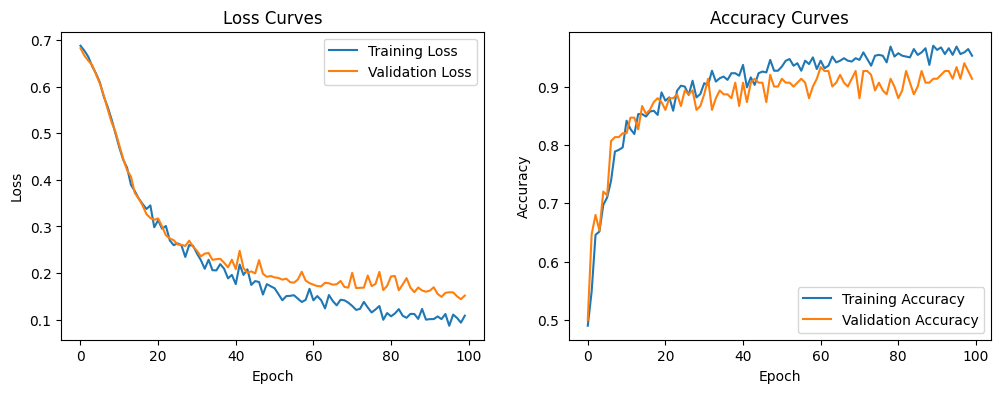

In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Generate a synthetic classification dataset
np.random.seed(42)
X = np.random.rand(1000, 10)
y = (np.sum(X, axis=1) > 5).astype(int)  # Binary classification: 1 if sum of features > 5, else 0

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=10))
model.add(Dropout(0.2))  # Add dropout for regularization
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()

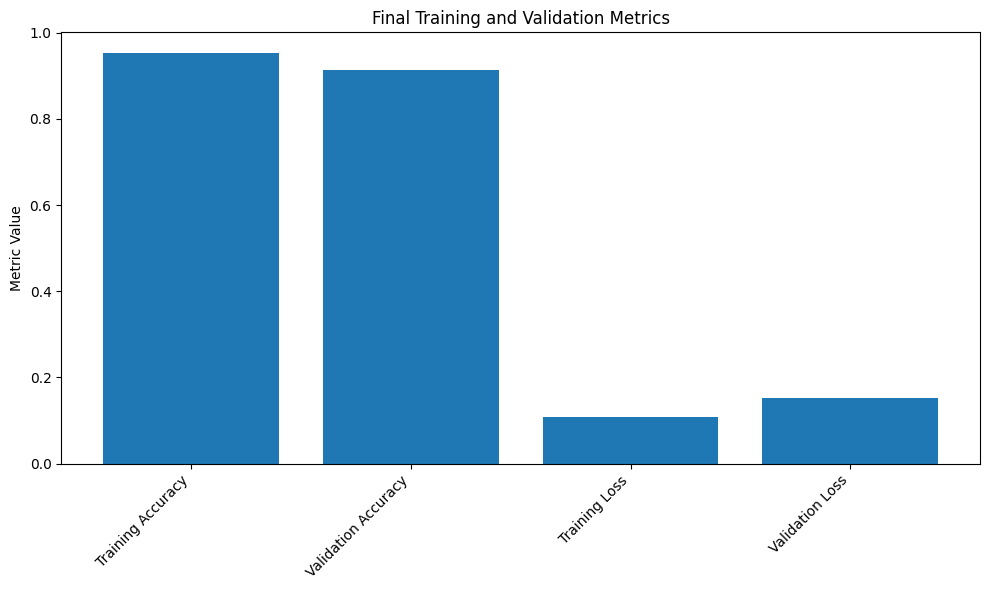

In [74]:
# Extract final metrics
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Group metrics for plotting
labels = ['Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss']
values = [final_train_accuracy, final_val_accuracy, final_train_loss, final_val_loss]

# Create a bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(labels, values)

# Customize the plot
plt.ylabel('Metric Value')
plt.title('Final Training and Validation Metrics')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [75]:
history.history['accuracy']

[0.49000000953674316,
 0.5485714077949524,
 0.645714282989502,
 0.6514285802841187,
 0.6971428394317627,
 0.7099999785423279,
 0.7385714054107666,
 0.7885714173316956,
 0.7914285659790039,
 0.795714259147644,
 0.8414285778999329,
 0.8271428346633911,
 0.8185714483261108,
 0.8528571724891663,
 0.8528571724891663,
 0.8485714197158813,
 0.8571428656578064,
 0.8585714101791382,
 0.8514285683631897,
 0.8899999856948853,
 0.8757143020629883,
 0.881428599357605,
 0.8585714101791382,
 0.8928571343421936,
 0.9014285802841187,
 0.8999999761581421,
 0.8857142925262451,
 0.9100000262260437,
 0.881428599357605,
 0.8871428370475769,
 0.9057142734527588,
 0.9028571248054504,
 0.927142858505249,
 0.9085714221000671,
 0.9142857193946838,
 0.9171428680419922,
 0.9114285707473755,
 0.9228571653366089,
 0.9228571653366089,
 0.918571412563324,
 0.9371428489685059,
 0.8985714316368103,
 0.9157142639160156,
 0.9028571248054504,
 0.9228571653366089,
 0.9257143139839172,
 0.9242857098579407,
 0.945714294910430

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

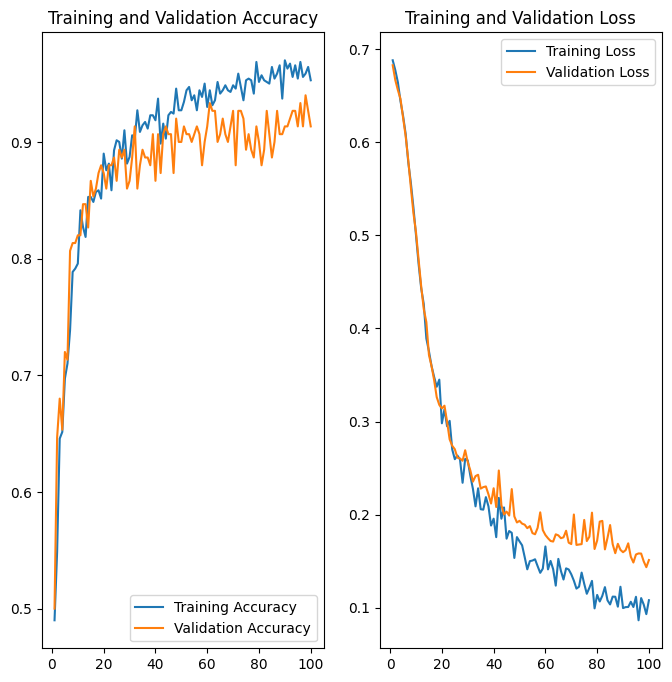

In [78]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(acc) + 1), acc, label='Training Accuracy')  # Use len(acc) to get the number of epochs
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(10, input_dim=8, activation='relu'))  # Existing layer

# Add more layers below
model.add(Dense(6, activation='relu'))  # Second hidden layer
model.add(Dense(4, activation='relu'))  # Third hidden layer
model.add(Dense(1))  # Output layer (adjust based on your task)

# Now you can save the model
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [80]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predicted energy amounts for a sample subset of data can be seen in the figure above. The predicted amounts follow the actual amounts ("Ground truth") relatively well.